**Problem statement**: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

In [1]:
# 1. Fetching ZIP data from drive
# 2. mounting it to colab
# 3. Extracting the images
from google.colab import drive
drive.mount('/content/drive')
!unzip "/content/drive/MyDrive/Colab Notebooks/CNN_assignment.zip"

Mounted at /content/drive
Archive:  /content/drive/MyDrive/Colab Notebooks/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic

### Importing all the important libraries

In [2]:
# Import the required libraries

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL
import PIL.Image
from tensorflow import keras
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Activation, BatchNormalization, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.utils import image_dataset_from_directory

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images

# Train dataset
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")

# Test dataset
data_dir_test = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

In [4]:
# Counting the number of images in train dataset
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print ("Total images in train directory : ", image_count_train)

# Counting the number of images in test dataset
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print ("Total images in test directory : ", image_count_test)

Total images in train directory :  2239
Total images in test directory :  118


### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

Using 80% of the images for training, and 20% for validation.

In [6]:
# Creating train dataset using image_dataset_from_directory.
# with seed value of 123 and given image parameters as defined above
train_ds = image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
# Creating validation dataset from the train directory
# with seed value of 123
val_ds = image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# Listing out all the classes of skin cancer and storing them in the list in alphabetical order
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### The below code will visualize 1 instance of each class 

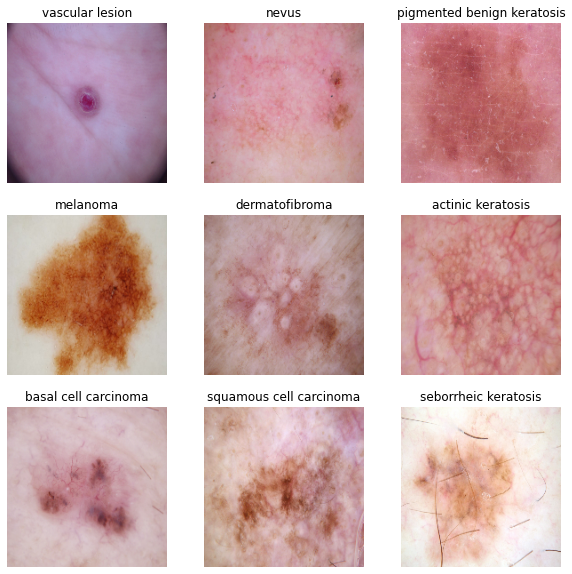

In [9]:
# Choosing the display the images in a grid size 3 X 3
plt.figure(figsize=(10, 10))

# Fetching the images and labels for 2 batches of images
# Assuming all images will be picked up in 2 batches
take_dataset_images = train_ds.take(5)

# Set is required to check if a particular image has already been visited from tf
visited_image_labels = set()

# Iterating over all the labels and plotting the image
# If an image is already plotted, it will skip to the next image
def plot_images(images, label, i, k):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(images[k].numpy().astype("uint8"))
  plt.title(class_names[label])
  plt.axis('off')

completed = False
i = 0
for l in range(5):
  images, labels = list(take_dataset_images)[l]
  k = 0
  for label in labels.numpy():
    if label in visited_image_labels:
      k+=1
      continue
    plot_images(images, label, i, k)
    visited_image_labels.add(label)
    if len(visited_image_labels) == 9:
      completed = True
      break
    k+=1
    i+=1
  if completed:
    break

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
- Creating a CNN model, which can accurately detect 9 classes present in the dataset. 
- Used ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
# Rescaled normalised layer

normalisation_layer = keras.Sequential([Rescaling(1./255, input_shape=(img_height, img_width, 3))])
normalisation_layer

In [12]:
num_classes = len(class_names)

# Creating a baseline model with 5 convolution layers 
# each followed by a max-pooling layer
# fully-connected layers at the end

model = keras.Sequential()
model.add(normalisation_layer)

model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)       

### Compile the model
Compiling the model using `adam` optimizer and `sparse_categorical_crossentropy` as a loss function. Using `accuracy` as a metric.

In [14]:
# Using adam optimiser to compile the model
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

### Train the model

In [15]:
# Training the model with 20 epochs each with a batch size of 32
epochs = 20
history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs,
  shuffle=True
)

Epoch 1/20
56/56 [==============================] - 31s 124ms/step - loss: 2.0013 - accuracy: 0.1936 - val_loss: 1.8356 - val_accuracy: 0.3199
Epoch 2/20
56/56 [==============================] - 3s 56ms/step - loss: 1.7590 - accuracy: 0.3544 - val_loss: 1.7510 - val_accuracy: 0.3602
Epoch 3/20
56/56 [==============================] - 3s 54ms/step - loss: 1.6055 - accuracy: 0.4241 - val_loss: 1.5501 - val_accuracy: 0.4720
Epoch 4/20
56/56 [==============================] - 3s 54ms/step - loss: 1.5632 - accuracy: 0.4397 - val_loss: 1.5857 - val_accuracy: 0.4743
Epoch 5/20
56/56 [==============================] - 4s 63ms/step - loss: 1.4923 - accuracy: 0.4754 - val_loss: 1.4249 - val_accuracy: 0.5101
Epoch 6/20
56/56 [==============================] - 3s 55ms/step - loss: 1.4286 - accuracy: 0.5033 - val_loss: 1.4233 - val_accuracy: 0.5257
Epoch 7/20
56/56 [==============================] - 3s 54ms/step - loss: 1.3769 - accuracy: 0.5195 - val_loss: 1.4536 - val_accuracy: 0.4966
Epoch 8/20


### Visualizing training results

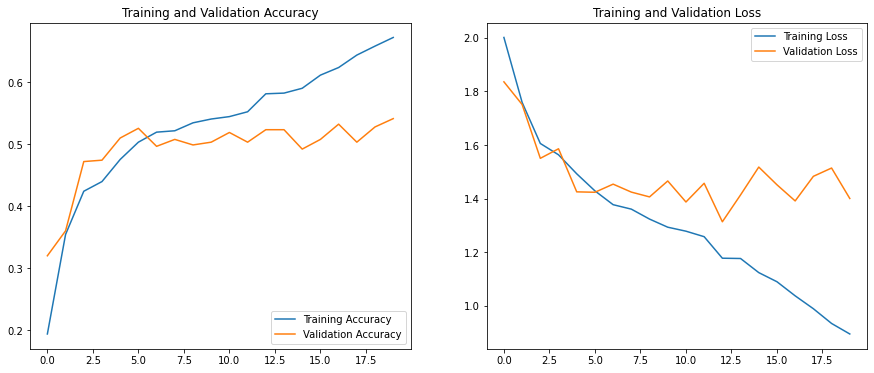

In [16]:
# Visualising the accuracy and loss between train and validation results.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observations


*   The training and validation accuracy are diverging which indicates that the model tends to overfit with the baseline model
*   We can also see that due to overfitting, the loss also tend to diverge and starts increasing after 17th epoch which is `~1.37`



#### Data Augmentation
##### This process will try to transform the image by resizing, zooming and flipping the image based on a random probability factor. This is very useful to generalise a model. Let's create a data augmentation layer and apply it to a particular image to see how it works.

In [17]:
# Creating a data augmentation layer
# 1. RandomFlip : to flip the image horizontally
# 2. RandomRotation : Rotate the image
# 3. RandomZoom : Zoom the image
data_augmentation = keras.Sequential(
  [
    RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    RandomRotation(0.1),
    RandomZoom(0.1),
  ]
)

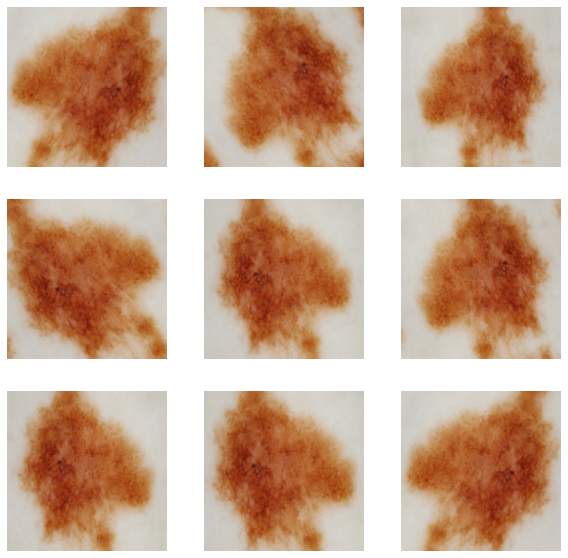

In [18]:
# Visualizing how the augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Augmented Model


In [19]:
# Creating an augmented model with the same number of convolution layers as the baseline model
# each followed by a max-pooling layer
# and fully-connected layers at the end

model = keras.Sequential()
model.add(normalisation_layer)
model.add(data_augmentation)

model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

### Model Summary

In [20]:
# View the model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 90, 90, 32)        4640      
                                                      

### Compiling the model

In [21]:
# Using adam optimiser to compile the model
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

### Training the model

In [22]:
# Training the model with 20 epochs each with a batch size of 32
history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs,
  shuffle=True
)

Epoch 1/20
56/56 [==============================] - 6s 77ms/step - loss: 2.0714 - accuracy: 0.2003 - val_loss: 2.1199 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 4s 67ms/step - loss: 2.0367 - accuracy: 0.1942 - val_loss: 2.0463 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 4s 67ms/step - loss: 2.0214 - accuracy: 0.2037 - val_loss: 2.0240 - val_accuracy: 0.2394
Epoch 4/20
56/56 [==============================] - 4s 67ms/step - loss: 1.9104 - accuracy: 0.2902 - val_loss: 1.8589 - val_accuracy: 0.2998
Epoch 5/20
56/56 [==============================] - 4s 69ms/step - loss: 1.7575 - accuracy: 0.3443 - val_loss: 1.7715 - val_accuracy: 0.3468
Epoch 6/20
56/56 [==============================] - 4s 66ms/step - loss: 1.7006 - accuracy: 0.3789 - val_loss: 1.6307 - val_accuracy: 0.4116
Epoch 7/20
56/56 [==============================] - 4s 66ms/step - loss: 1.6002 - accuracy: 0.4302 - val_loss: 1.6051 - val_accuracy: 0.4228
Epoch 8/20
56

### Visualizing the results

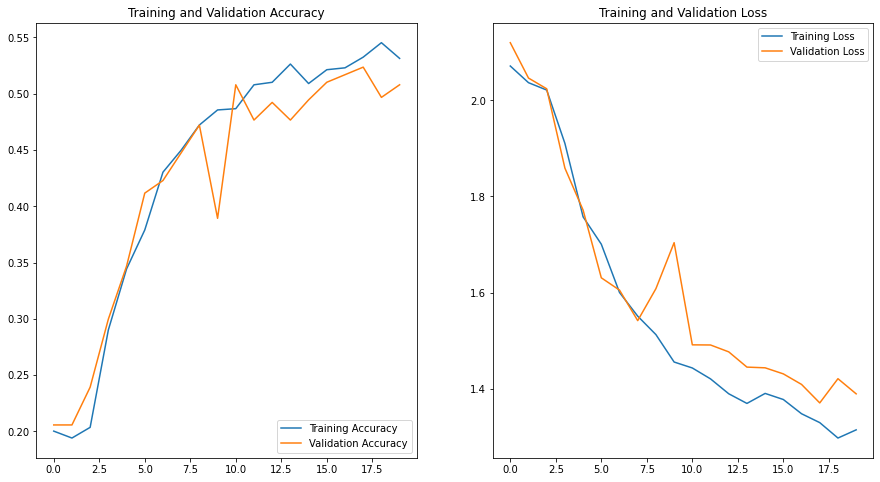

In [23]:
# Visualizing the results of augmented model
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observations
- Although we improved the model by avoid the overfitting, we can still see that the model is unable to learn appropriate patterns in the image.
- This is due to limited number of training data. We need to increase the training dataset so that the CNN model is able to capture important features and able to classify images with improvised accuracy.

--------------------------

##Class Distribution
#### Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

disease
actinic keratosis             114
basal cell carcinoma          376
dermatofibroma                 95
melanoma                      438
nevus                         357
pigmented benign keratosis    462
seborrheic keratosis           77
squamous cell carcinoma       181
vascular lesion               139
Name: disease, dtype: int64


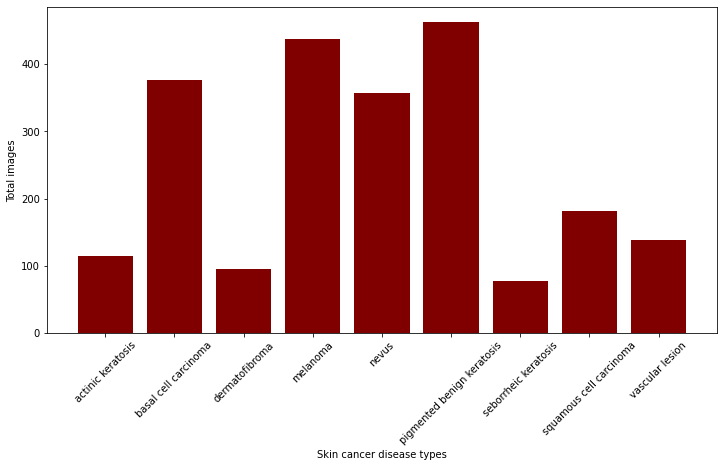

In [24]:
import glob

# Plotting the barplot for each class along with their count
def plot_disease_classes(df):
  plt.figure(figsize=(12,6))
  plt.xticks(rotation=45)
  plt.xlabel('Skin cancer disease types')
  plt.ylabel('Total images')
  plt.bar(df.keys(), df.values, color='maroon')
  plt.show()

# Fetch the class names from directory and store it in dataframe along with their counts
disease_classes_1 = [os.path.basename(os.path.dirname(x)) for x in glob.glob(os.path.join(data_dir_train, '*', '*.jpg'))]
df = pd.DataFrame({'disease': disease_classes_1})
df = df.groupby('disease')['disease'].count()
# Printing the keys and values of the dataframe
print (df)
plot_disease_classes(df)

### Findings : 
#### - Which class has the least number of samples? : **`seborrheic keratosis`**
#### - Which classes dominate the data in terms proportionate number of samples? : **`pigmented benign keratosis`**


### Rectifying the class imbalance
#### Using a python package `Augmentor` to add more samples across all classes so that none of the classes have very few samples.


In [25]:
# Install Augmentor package
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [26]:
# Define the path to Train dataset
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

# Import Augmentor package
import Augmentor

# For each of the class names, create 500 samples of augmented data
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6277207850>: 100%|██████████| 500/500 [00:23<00:00, 20.91 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F6276F21090>: 100%|██████████| 500/500 [00:25<00:00, 19.95 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F62783480D0>: 100%|██████████| 500/500 [00:25<00:00, 19.87 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F6276F26250>: 100%|██████████| 500/500 [02:11<00:00,  3.80 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7F6276EEA310>: 100%|██████████| 500/500 [01:44<00:00,  4.78 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6276217990>: 100%|██████████| 500/500 [00:21<00:00, 23.46 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F6276F26110>: 100%|██████████| 500/500 [00:49<00:00, 10.00 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F627726ED90>: 100%|██████████| 500/500 [00:22<00:00, 22.61 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6276ED56D0>: 100%|██████████| 500/500 [00:21<00:00, 23.32 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types. Lets take a look at total count of augmented images.

In [27]:
# Printing total number of image samples

image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [28]:
data_dir_train = pathlib.Path('/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/')
print (len(list(data_dir_train.glob('**/*.jpg'))))

6739


disease
actinic keratosis             614
basal cell carcinoma          876
dermatofibroma                595
melanoma                      938
nevus                         857
pigmented benign keratosis    962
seborrheic keratosis          577
squamous cell carcinoma       681
vascular lesion               639
Name: disease, dtype: int64


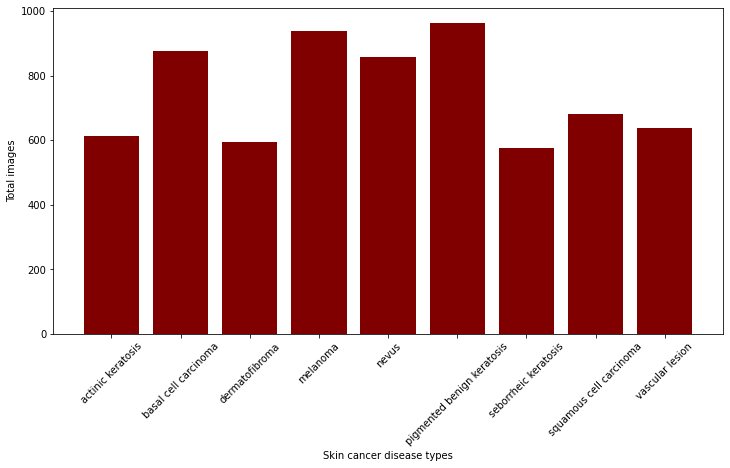

In [29]:
# Checking the images obtained by Augmentor in the output directory
disease_classes_2 = [os.path.basename(os.path.dirname(os.path.dirname(x))) for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
df = pd.DataFrame({'disease': disease_classes_1 + disease_classes_2})
df = df.groupby('disease')['disease'].count()
# Printing the keys and values of the dataframe
print (df)
plot_disease_classes(df)

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [30]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [31]:
# Create train set
train_ds = image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [32]:
# Create validation set
val_ds = image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [33]:
# Creating a modified model with 5 convolution layers 
# each followed by a max-pooling layer
# fully-connected layers at the end

model = keras.Sequential()
model.add(normalisation_layer)

model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

In [34]:
# View model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 90, 90, 16)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [35]:
# Using adam optimiser to compile the model
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [36]:
epochs = 30

# Fitting the model with 30 epochs each with batch_size of 32
history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs,
  shuffle=True
)

Epoch 1/30
169/169 [==============================] - 60s 346ms/step - loss: 2.0721 - accuracy: 0.1958 - val_loss: 1.8988 - val_accuracy: 0.2999
Epoch 2/30
169/169 [==============================] - 34s 196ms/step - loss: 1.7636 - accuracy: 0.3103 - val_loss: 1.5951 - val_accuracy: 0.3950
Epoch 3/30
169/169 [==============================] - 34s 195ms/step - loss: 1.5669 - accuracy: 0.3952 - val_loss: 1.4917 - val_accuracy: 0.4276
Epoch 4/30
169/169 [==============================] - 36s 206ms/step - loss: 1.4863 - accuracy: 0.4201 - val_loss: 1.5967 - val_accuracy: 0.4202
Epoch 5/30
169/169 [==============================] - 34s 194ms/step - loss: 1.3516 - accuracy: 0.4731 - val_loss: 1.3229 - val_accuracy: 0.4840
Epoch 6/30
169/169 [==============================] - 34s 195ms/step - loss: 1.3044 - accuracy: 0.4935 - val_loss: 1.3077 - val_accuracy: 0.5085
Epoch 7/30
169/169 [==============================] - 34s 197ms/step - loss: 1.2110 - accuracy: 0.5315 - val_loss: 1.1739 - val_ac

#### **Todo:**  Visualize the model results

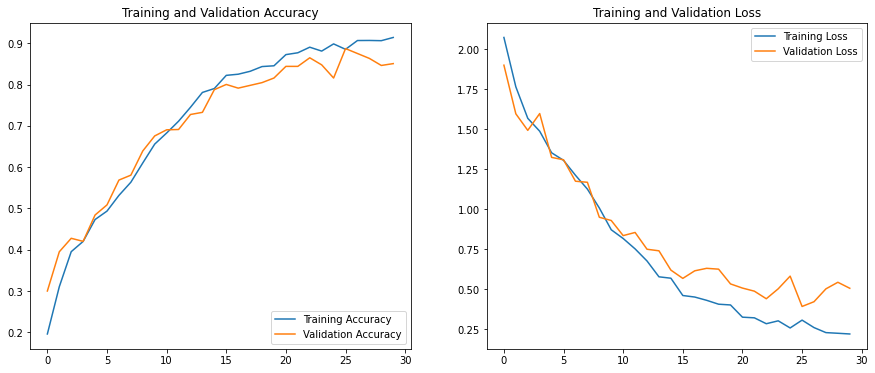

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings:  
#### - With more number of training samples, the modified model is able to get a better accuracy as compared to the previous models.
#### - We also got rid of overfitting and underfitting of the model



## Test data Predictions
#### We will get the images from test directory and evaluate the final model to calculate the accuracy

In [38]:
# Fetch test data
test_ds = image_dataset_from_directory(
    data_dir_test,
    color_mode='rgb',
    image_size=(img_height, img_width),
    batch_size=batch_size
)
print(test_ds.class_names)

Found 118 files belonging to 9 classes.
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [39]:
# Normalizing the test images in the range [0,1]
# normalised_layer = tf.keras.layers.Rescaling(1./255)
# test_ds1 = test_ds.map(lambda x, y: (normalised_layer(x), y))

In [40]:
model.evaluate(test_ds)

4/4 [==============================] - 4s 106ms/step - loss: 12.2639 - accuracy: 0.1356


[12.263949394226074, 0.1355932205915451]

------------